In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import tempfile

In [2]:
# Step 1: Load and Normalize Data (3NF)
# ----------------------------
train_path = "train.csv"
train_data = pd.read_csv(train_path)



In [3]:
# Create SQLite connection
conn = sqlite3.connect('mobile_specs.db')
cursor = conn.cursor()

# Drop existing tables if they exist
cursor.execute("DROP TABLE IF EXISTS Mobile;")
cursor.execute("DROP TABLE IF EXISTS Features;")
cursor.execute("DROP TABLE IF EXISTS Camera;")
cursor.execute("DROP TABLE IF EXISTS Display;")
cursor.execute("DROP TABLE IF EXISTS Processor;")
cursor.execute("DROP TABLE IF EXISTS Price;")

# Create Mobile table
cursor.execute("""
CREATE TABLE Mobile (
    id INTEGER PRIMARY KEY,
    battery_power INTEGER,
    clock_speed REAL,
    m_dep REAL,
    mobile_wt INTEGER,
    ram INTEGER,
    int_memory INTEGER,
    talk_time INTEGER
);
""")

# Create Features table
cursor.execute("""
CREATE TABLE Features (
    id INTEGER PRIMARY KEY,
    blue INTEGER,
    dual_sim INTEGER,
    four_g INTEGER,
    three_g INTEGER,
    touch_screen INTEGER,
    int_memory INTEGER,
    wifi INTEGER,
    FOREIGN KEY (id) REFERENCES Mobile (id)
);
""")

# Create Camera table
cursor.execute("""
CREATE TABLE Camera (
    id INTEGER PRIMARY KEY,
    fc INTEGER,
    pc INTEGER,
    sc_h INTEGER,
    sc_w INTEGER,
    FOREIGN KEY (id) REFERENCES Mobile (id)
);
""")

# Create Display table
cursor.execute("""
CREATE TABLE Display (
    id INTEGER PRIMARY KEY,
    px_height INTEGER,
    px_width INTEGER,
    FOREIGN KEY (id) REFERENCES Mobile (id)
);
""")

# Create Processor table
cursor.execute("""
CREATE TABLE Processor (
    id INTEGER PRIMARY KEY,
    n_cores INTEGER,
    FOREIGN KEY (id) REFERENCES Mobile (id)
);
"""
)

cursor.execute("""
CREATE TABLE Price (
    id INTEGER PRIMARY KEY,
    price_range INTEGER,
    FOREIGN KEY (id) REFERENCES Mobile (id)
);
"""
)

# Commit the table creation
conn.commit()

# Populate the tables using your dataset (assuming `df` is the loaded dataset)
df = train_data

# Mobile Table
mobile_cols = ['id', 'battery_power', 'clock_speed', 'm_dep', 'mobile_wt', 'ram', 'int_memory', 'talk_time']
df[mobile_cols].to_sql('Mobile', conn, if_exists='append', index=False)

# Features Table
features_cols = ['id', 'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
df[features_cols].to_sql('Features', conn, if_exists='append', index=False)

# Camera Table
camera_cols = ['id', 'fc', 'pc', 'sc_h', 'sc_w']
df[camera_cols].to_sql('Camera', conn, if_exists='append', index=False)

# Display Table
display_cols = ['id', 'px_height', 'px_width']
df[display_cols].to_sql('Display', conn, if_exists='append', index=False)

# Processor Table
processor_cols = ['id', 'n_cores']
df[processor_cols].to_sql('Processor', conn, if_exists='append', index=False)

# Processor Table
price_cols = ['id', 'price_range']
df[price_cols].to_sql('Price', conn, if_exists='append', index=False)

# Verify tables
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

print("Tables created:", tables)

Tables created: [('Mobile',), ('Features',), ('Camera',), ('Display',), ('Processor',), ('Price',)]


In [4]:
query = """
SELECT 
    m.id, m.battery_power, m.clock_speed, m.m_dep, m.mobile_wt, m.ram, m.int_memory, m.talk_time,
    f.blue, f.dual_sim, f.four_g, f.three_g, f.touch_screen, f.wifi,
    c.fc, c.pc, c.sc_h, c.sc_w,
    d.px_height, d.px_width,
    p.n_cores,
    pr.price_range
FROM 
    Mobile m
JOIN 
    Features f ON m.id = f.id
JOIN 
    Camera c ON m.id = c.id
JOIN 
    Display d ON m.id = d.id
JOIN 
    Processor p ON m.id = p.id
JOIN 
    Price pr ON m.id = pr.id
"""

# Load the data into a Pandas DataFrame
df_joined = pd.read_sql_query(query, conn)

conn.close()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2000 non-null   int64  
 1   battery_power  2000 non-null   int64  
 2   blue           2000 non-null   int64  
 3   clock_speed    2000 non-null   float64
 4   dual_sim       2000 non-null   int64  
 5   fc             2000 non-null   int64  
 6   four_g         2000 non-null   int64  
 7   int_memory     2000 non-null   int64  
 8   m_dep          2000 non-null   float64
 9   mobile_wt      2000 non-null   int64  
 10  n_cores        2000 non-null   int64  
 11  pc             2000 non-null   int64  
 12  px_height      2000 non-null   int64  
 13  px_width       2000 non-null   int64  
 14  ram            2000 non-null   int64  
 15  sc_h           2000 non-null   int64  
 16  sc_w           2000 non-null   int64  
 17  talk_time      2000 non-null   int64  
 18  three_g 

In [6]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2000 non-null   int64  
 1   battery_power  2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   m_dep          2000 non-null   float64
 4   mobile_wt      2000 non-null   int64  
 5   ram            2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   talk_time      2000 non-null   int64  
 8   blue           2000 non-null   int64  
 9   dual_sim       2000 non-null   int64  
 10  four_g         2000 non-null   int64  
 11  three_g        2000 non-null   int64  
 12  touch_screen   2000 non-null   int64  
 13  wifi           2000 non-null   int64  
 14  fc             2000 non-null   int64  
 15  pc             2000 non-null   int64  
 16  sc_h           2000 non-null   int64  
 17  sc_w           2000 non-null   int64  
 18  px_heigh

In [7]:
print(df_joined.describe())

                id  battery_power  clock_speed        m_dep    mobile_wt  \
count  2000.000000    2000.000000  2000.000000  2000.000000  2000.000000   
mean   1000.500000    1238.518500     1.522250     0.501750   140.249000   
std     577.494589     439.418206     0.816004     0.288416    35.399655   
min       1.000000     501.000000     0.500000     0.100000    80.000000   
25%     500.750000     851.750000     0.700000     0.200000   109.000000   
50%    1000.500000    1226.000000     1.500000     0.500000   141.000000   
75%    1500.250000    1615.250000     2.200000     0.800000   170.000000   
max    2000.000000    1998.000000     3.000000     1.000000   200.000000   

               ram   int_memory    talk_time       blue     dual_sim  ...  \
count  2000.000000  2000.000000  2000.000000  2000.0000  2000.000000  ...   
mean   2124.213000    32.046500    11.011000     0.4950     0.509500  ...   
std    1084.732044    18.145715     5.463955     0.5001     0.500035  ...   
min    

Training Data Overview:


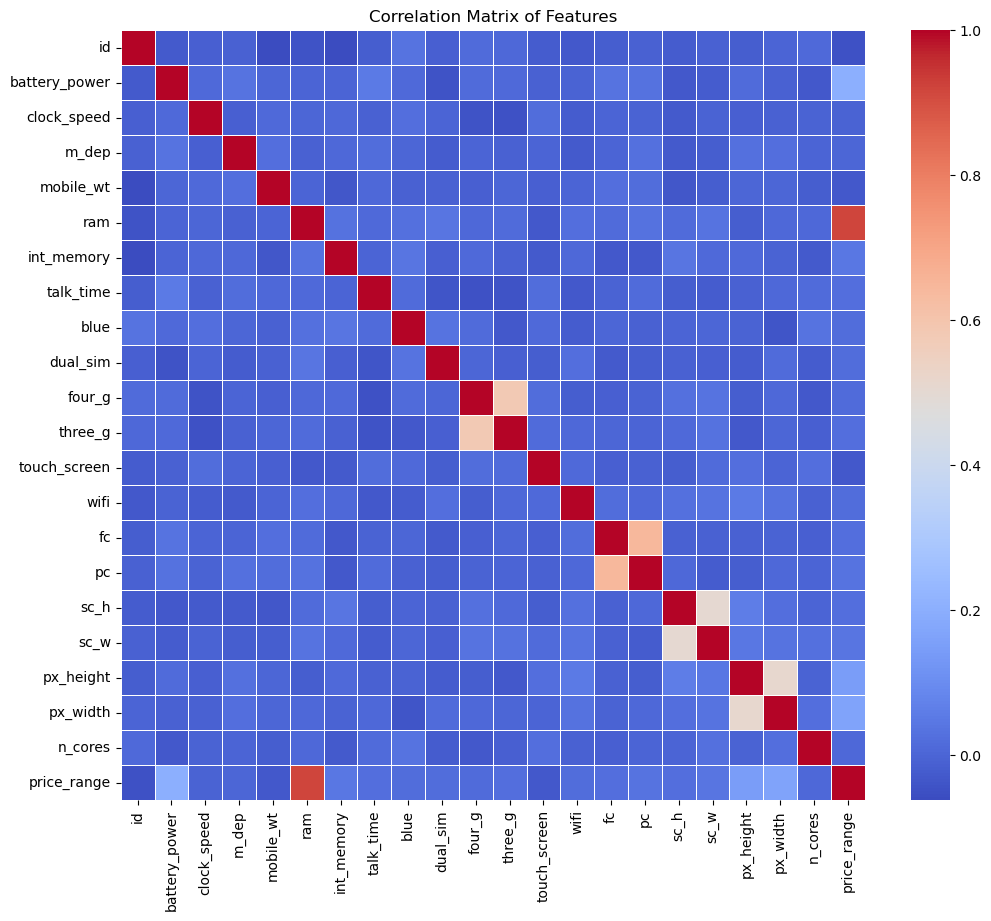

In [8]:
print("Training Data Overview:")

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_joined.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [9]:
df_joined.nunique()

id               2000
battery_power    1094
clock_speed        26
m_dep              10
mobile_wt         121
ram              1562
int_memory         63
talk_time          19
blue                2
dual_sim            2
four_g              2
three_g             2
touch_screen        2
wifi                2
fc                 20
pc                 21
sc_h               15
sc_w               19
px_height        1137
px_width         1109
n_cores             8
price_range         4
dtype: int64

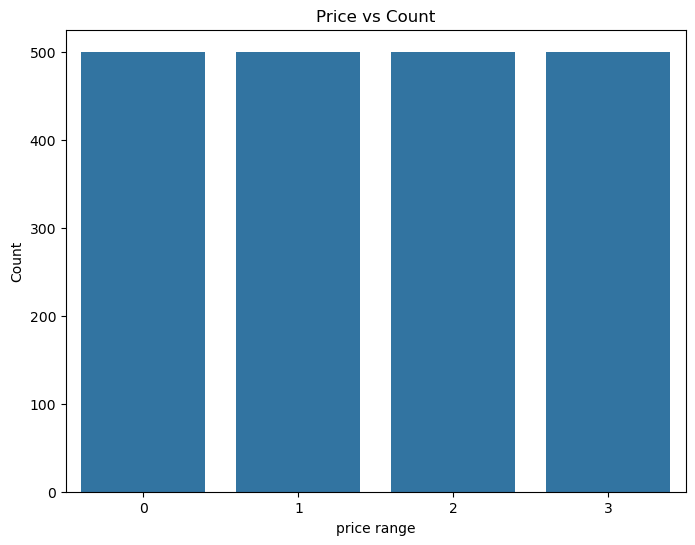

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='price_range', data=df_joined) 
plt.title('Price vs Count')
plt.xlabel('price range')
plt.ylabel("Count")
plt.show()

In [11]:
y = df_joined['price_range']
X = df_joined.drop(['price_range'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape

(1500, 21)

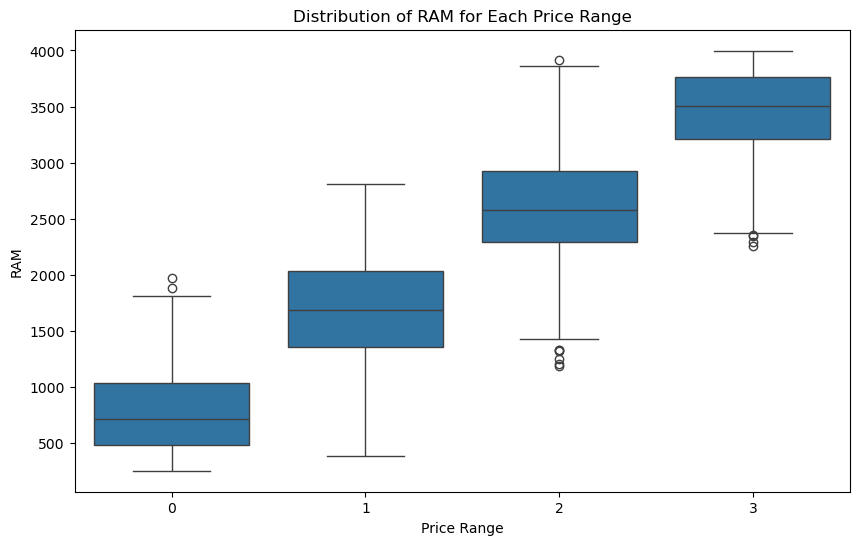

In [12]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.boxplot(x='price_range', y='ram', data=df_joined)
plt.title('Distribution of RAM for Each Price Range')
plt.xlabel('Price Range')
plt.ylabel('RAM')
plt.show()

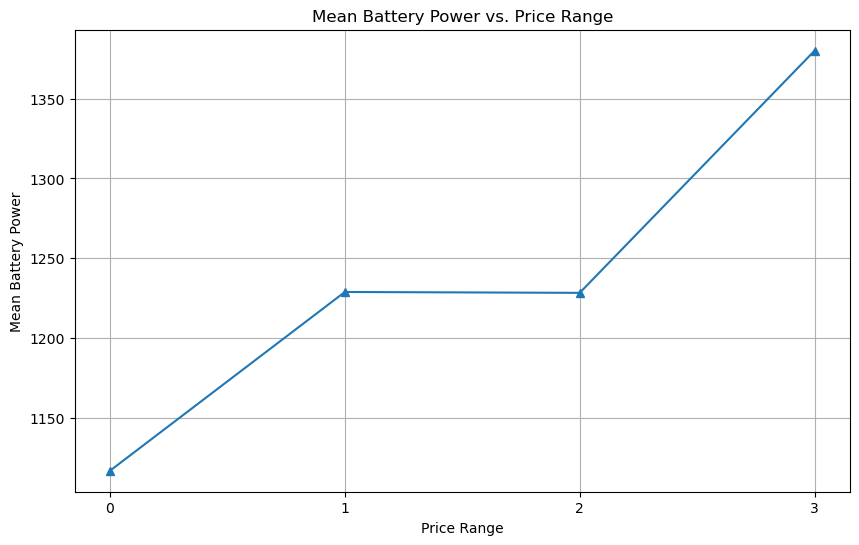

In [13]:
battery_by_price = df_joined.groupby('price_range')['battery_power'].mean()
plt.figure(figsize=(10, 6))
battery_by_price.plot(kind='line', marker='^')
plt.title('Mean Battery Power vs. Price Range')
plt.xlabel('Price Range')
plt.ylabel('Mean Battery Power')
plt.xticks(battery_by_price.index)
plt.grid(True)
plt.show()

In [14]:
!pip install mlflow

In [15]:
import dagshub
dagshub.init(repo_owner='sreenathreddy6633', repo_name='price-detection', mlflow=True)

Accessing as sreenathreddy6633

Initialized MLflow to track repo "sreenathreddy6633/price-detection"

Repository sreenathreddy6633/price-detection initialized!

In [23]:
import mlflow

mlflow.set_tracking_uri("https://dagshub.com/sreenathreddy6633/price-detection.mlflow")
mlflow.set_experiment("Experiment_1")

2024/12/20 04:20:39 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_1' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1c36711f23c84b3f8eab8eb80ae4d531', creation_time=1734686438983, experiment_id='9', last_update_time=1734686438983, lifecycle_stage='active', name='Experiment_1', tags={}>

In [110]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
import mlflow
from mlflow import log_param, log_metric
from dagshub import DAGsHubLogger,  dagshub_logger


# Split numerical and categorical columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Define preprocessing steps
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

log_transformer = FunctionTransformer(np.log1p, validate=True)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("log_transform", log_transformer),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
}

# Define hyperparameter grid
param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__penalty": ["l2"],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",
    cv=cv,
    return_train_score=True,
    verbose=3,
    n_jobs=-1
)

with mlflow.start_run() as run:
    # Fit the GridSearchCV
    grid_search.fit(X, y)

    # Log best parameters
    mlflow.log_params(grid_search.best_params_)

    # Log mean and std of cross-validation scores
    cv_results = grid_search.cv_results_
    f1_mean = np.mean(cv_results["mean_test_f1"])
    f1_std = np.std(cv_results["mean_test_f1"])
    mlflow.log_metric("f1_mean", f1_mean)
    mlflow.log_metric("f1_std", f1_std)

    # Log confusion matrix on the whole training data
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    cm_str = str(cm.tolist())

    mlflow.log_text(cm_str, "confusion_matrix/confusion_matrix.txt")

    # Print results
    print(f"Best F1 Score (CV): {f1_mean:.3f} ± {f1_std:.3f}")

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best F1 Score (CV): 0.852 ± 0.096
🏃 View run unleashed-fox-299 at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/15/runs/18830da3c84846eca80649a413f06b6f
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/15


# Experiment 2

In [112]:

from sklearn.metrics import accuracy_score, f1_score
# Define models for the experiment
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBClassifier": XGBClassifier(random_state=42, n_jobs=-1)
}

# Define preprocessing pipeline
preprocessing = Pipeline([
    ("scaler", StandardScaler())
])

# Setup MLFlow with DagsHub
mlflow.set_experiment("Experiment_2")

# Run models and log results
with dagshub.dagshub_logger() as logger:
    for model_name, model in models.items():
        with mlflow.start_run(run_name=model_name):
            # Preprocessing
            X_train_preprocessed = preprocessing.fit_transform(X_train)
            X_test_preprocessed = preprocessing.transform(X_test)

            # Model fitting
            model.fit(X_train_preprocessed, y_train)

            # Predictions
            y_pred = model.predict(X_test_preprocessed)

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="weighted")

            # Log parameters, metrics, and model
            log_param("model", model_name)
            log_metric("accuracy", acc)
            log_metric("f1_score", f1)

            logger.log_metrics({"accuracy": acc, "f1_score": f1})
            mlflow.sklearn.log_model(model, model_name)
            print(f"{model_name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")


2024/12/20 14:54:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression: Accuracy = 0.9620, F1 Score = 0.9619
🏃 View run LogisticRegression at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/10/runs/aff57b60cc034354add104524cb93f54
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/10


2024/12/20 14:54:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier: Accuracy = 0.6400, F1 Score = 0.5770
🏃 View run RidgeClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/10/runs/f32003339efd4dec85b697a9f66b408e
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/10


2024/12/20 14:55:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier: Accuracy = 0.8720, F1 Score = 0.8719
🏃 View run RandomForestClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/10/runs/cfd3f4b61f024568a13145197a098f41
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/10


2024/12/20 14:55:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBClassifier: Accuracy = 0.9000, F1 Score = 0.9000
🏃 View run XGBClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/10/runs/94574fe245be44bcb31cbcc5631a5c62
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/10


# Experiment 3

In [28]:
# Feature interactions
def feature_engineering(df):
    df_fe = df.copy()
    df_fe["battery_to_weight_ratio"] = df_fe["battery_power"] / df_fe["mobile_wt"]
    df_fe["ram_to_core_ratio"] = df_fe["ram"] / df_fe["n_cores"]
    # Scaling features
    df_fe["scaled_clock_speed"] = np.log1p(df_fe["clock_speed"])
    # Additional combinations
    df_fe["px_resolution"] = df_fe["px_height"] * df_fe["px_width"] 
    df_fe["sc_aspect_ratio"] = df_fe["sc_h"] / np.maximum(df_fe["sc_w"], 1)
    df_fe.drop(['sc_h', 'clock_speed'], axis = 1)
    return df_fe

In [29]:
X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)

print("X_train_fe type:", type(X_train_fe))
print("X_test_fe type:", type(X_test_fe))

X_train_fe type: <class 'pandas.core.frame.DataFrame'>
X_test_fe type: <class 'pandas.core.frame.DataFrame'>


In [30]:

preprocessing = Pipeline([
    ("scaler", StandardScaler())
])

# Setup MLFlow with DagsHub
mlflow.set_tracking_uri("https://dagshub.com/sreenathreddy6633/price-detection.mlflow")  # Replace with your DagsHub repo
mlflow.set_experiment("Experiment_3")

# Run models and log results
with dagshub.dagshub_logger() as logger:
    for model_name, model in models.items():
        with mlflow.start_run(run_name=model_name):
            # Preprocessing
            X_train_fe = preprocessing.fit_transform(X_train_fe)
            X_test_fe = preprocessing.transform(X_test_fe)

            # Model fitting
            model.fit(X_train_fe, y_train)

            # Predictions
            y_pred = model.predict(X_test_fe)

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="weighted")

            # Log parameters, metrics, and model
            log_param("model", model_name)
            log_metric("accuracy", acc)
            log_metric("f1_score", f1)

            logger.log_metrics({"accuracy": acc, "f1_score": f1})
            mlflow.sklearn.log_model(model, model_name)
            print(f"{model_name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")


2024/12/20 04:22:09 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_3' does not exist. Creating a new experiment.
2024/12/20 04:22:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression: Accuracy = 0.9500, F1 Score = 0.9499
🏃 View run LogisticRegression at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/11/runs/c77bd0fc4b8149d3923d021a438a2bd7
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/11


2024/12/20 04:22:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier: Accuracy = 0.6280, F1 Score = 0.5640
🏃 View run RidgeClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/11/runs/f6bc29f4baee476db4491ca2d49fe8a3
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/11


2024/12/20 04:22:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier: Accuracy = 0.8920, F1 Score = 0.8924
🏃 View run RandomForestClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/11/runs/9173dc4a702d47128573f40c010fe97f
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/11


2024/12/20 04:22:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBClassifier: Accuracy = 0.8980, F1 Score = 0.8983
🏃 View run XGBClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/11/runs/9b6c65a3542d49d89e54e31699460865
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/11


# Experiment 4

In [39]:
# Correlation Threshold
def correlation_threshold(data, threshold=0.8):
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

# Variance Threshold
def variance_threshold(data, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data.columns[~selector.get_support()]

# Feature Importance
def feature_importance(data, target, num_features=10):
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf.fit(data, target)
    importance = pd.DataFrame({
        "Feature": data.columns,
        "Importance": rf.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    return importance.head(num_features)

# Preprocess and split data
X_train_selected = X_train.copy()
y_train_selected = y_train.copy()

# Correlation Threshold
correlated_features = correlation_threshold(X_train_selected, threshold=0.8)
X_train_selected.drop(columns=correlated_features, inplace=True)

# Variance Threshold
low_variance_features = variance_threshold(X_train_selected, threshold=0.01)
X_train_selected.drop(columns=low_variance_features, inplace=True)

# Feature Importance
important_features = feature_importance(X_train_selected, y_train_selected, num_features=10)
X_train_selected = X_train_selected[important_features["Feature"]]

# Setup MLFlow with DagsHub
mlflow.set_tracking_uri("https://dagshub.com/sreenathreddy6633/price-detection.mlflow")  # Replace with your DagsHub repo
mlflow.set_experiment("Experiment_4")

# Log feature selection results
with dagshub_logger() as logger:
    with mlflow.start_run(run_name="Feature_Selection"):
        # Log parameters and features
        log_param("correlated_features_removed", correlated_features)
        log_param("low_variance_features_removed", low_variance_features)
        log_param("important_features", important_features["Feature"].tolist())

        # Log metrics and artifacts
        mlflow.log_text(str(important_features), "selected_features/selected_features.txt")
        print("Feature selection completed. Results logged in MLFlow.")

2024/12/20 04:23:24 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_4' does not exist. Creating a new experiment.


Feature selection completed. Results logged in MLFlow.
🏃 View run Feature_Selection at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12/runs/72bc70fbdd144873ba61fadfc245a34d
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12


In [41]:

preprocessing = Pipeline([
    ("scaler", StandardScaler())
])


# Run models and log results
with dagshub.dagshub_logger() as logger:
    for model_name, model in models.items():
        with mlflow.start_run(run_name=model_name):
            # Preprocessing
            X_train_fs = preprocessing.fit_transform(X_train[important_features['Feature']])
            X_test_fs = preprocessing.transform(X_test[important_features['Feature']])

            # Model fitting
            model.fit(X_train_fs, y_train)

            # Predictions
            y_pred = model.predict(X_test_fs)

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="weighted")

            # Log parameters, metrics, and model
            log_param("model", model_name)
            log_metric("accuracy", acc)
            log_metric("f1_score", f1)
            logger.log_metrics({"accuracy": acc, "f1_score": f1})
            mlflow.sklearn.log_model(model, model_name)
            print(f"{model_name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

2024/12/20 04:23:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression: Accuracy = 0.9720, F1 Score = 0.9719
🏃 View run LogisticRegression at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12/runs/67a1696f21d247328066e8a3d1caa54f
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12


2024/12/20 04:23:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier: Accuracy = 0.6000, F1 Score = 0.5134
🏃 View run RidgeClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12/runs/3862eeb0aadf457da1e4ab4587a1ed4c
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12


2024/12/20 04:23:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier: Accuracy = 0.9000, F1 Score = 0.8999
🏃 View run RandomForestClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12/runs/bc544089e6184f9797860bf1238e3138
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12


2024/12/20 04:24:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBClassifier: Accuracy = 0.8960, F1 Score = 0.8958
🏃 View run XGBClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12/runs/2080c72cfbc347a5a1486ca64a60d909
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/12


# Experiment 5

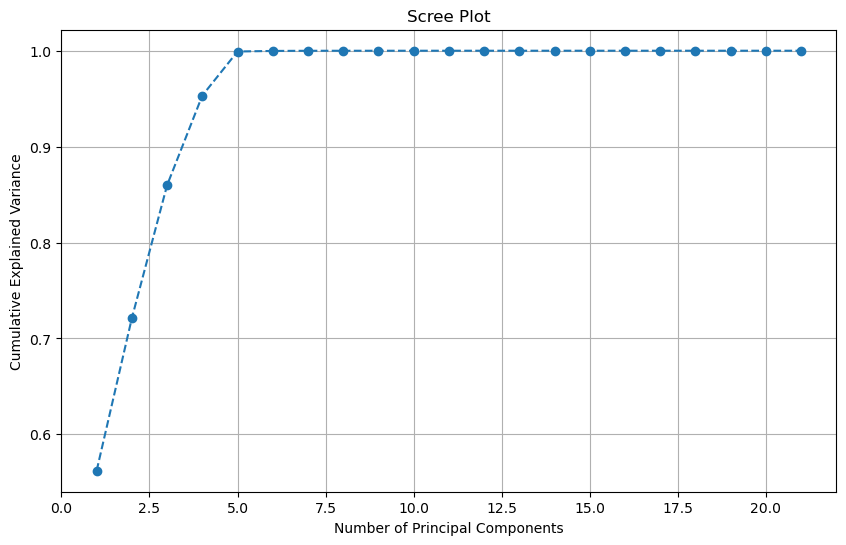

Number of components to retain for 95% variance: 4


In [43]:

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Calculate cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.show()

# Select the number of components to retain (e.g., 95% cumulative variance)
n_components = next(i for i, var in enumerate(cumulative_variance) if var >= 0.95) + 1
print(f"Number of components to retain for 95% variance: {n_components}")

# Transform data using the selected components
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [44]:
mlflow.set_experiment("Experiment_5")

with dagshub.dagshub_logger() as logger:
    for model_name, model in models.items():
        with mlflow.start_run(run_name=model_name):
            # Preprocessing
            X_train_reduced = preprocessing.fit_transform(X_train_reduced)
            X_test_reduced = preprocessing.transform(X_test_reduced)

            # Model fitting
            model.fit(X_train_reduced, y_train)

            # Predictions
            y_pred = model.predict(X_test_reduced)

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="weighted")

            # Log parameters, metrics, and model
            log_param("model", model_name)
            log_metric("accuracy", acc)
            log_metric("f1_score", f1)

            logger.log_metrics({"accuracy": acc, "f1_score": f1})
            mlflow.sklearn.log_model(model, model_name)
            print(f"{model_name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")


2024/12/20 04:24:14 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_5' does not exist. Creating a new experiment.
2024/12/20 04:24:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression: Accuracy = 0.9600, F1 Score = 0.9599
🏃 View run LogisticRegression at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/13/runs/c04e0a6e94134c52996fdf1b8f074247
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/13


2024/12/20 04:24:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier: Accuracy = 0.5780, F1 Score = 0.4737
🏃 View run RidgeClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/13/runs/ef11efbb094a4998981552b5a95e1e6d
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/13


2024/12/20 04:24:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier: Accuracy = 0.9240, F1 Score = 0.9242
🏃 View run RandomForestClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/13/runs/2ae2fc313aa442df81e4f9fe99ea7586
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/13


2024/12/20 04:24:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBClassifier: Accuracy = 0.9280, F1 Score = 0.9283
🏃 View run XGBClassifier at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/13/runs/1735032967ce4977b2ccda8829fd8e20
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/13


# Experiment 6

In [46]:
from sklearn.ensemble import StackingClassifier
#from sklearn.preprocessing import StandardScaler, FunctionTransformer
from dagshub import dagshub_logger
# Feature engineering
def hybrid_features(data):
    data = data.copy()
    data["battery_to_weight_ratio"] = data["battery_power"] / data["mobile_wt"]
    data["px_resolution"] = data["px_height"] * data["px_width"]
    return data

In [51]:
# Preprocessing pipeline
preprocessing = Pipeline([
    ("feature_engineering", FunctionTransformer(hybrid_features, validate=False)),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=1))  # Retain top 10 PCA components
])

# Preprocess data
X_train_transformed = preprocessing.fit_transform(X_train)
X_test_transformed = preprocessing.transform(X_test)

# Base models for stacking
base_models = [
    ("lr", RidgeClassifier(max_iter=1000, random_state=42)),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ("xgb", XGBClassifier(random_state=42, n_jobs=-1))
]

# Meta-model for stacking
meta_model = LogisticRegression(random_state=42)

# Stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

# Train and evaluate model
mlflow.set_experiment("Experiment_6")
with dagshub_logger() as logger:
    with mlflow.start_run(run_name="Custom_Stacked_Experiment"):
        # Fit stacking model
        stacking_model.fit(X_train_transformed, y_train)

        # Predictions
        y_pred = stacking_model.predict(X_test_transformed)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")

        # Log parameters and results
        log_param("base_models", [name for name, _ in base_models])
        log_param("meta_model", "RidgeClassifier")
        log_metric("accuracy", acc)
        log_metric("f1_score", f1)
        logger.log_metrics({"accuracy": acc, "f1_score": f1})

        # Log PCA variance
        explained_variance = preprocessing.named_steps["pca"].explained_variance_ratio_
        mlflow.log_param("explained_variance", explained_variance.tolist())

        print(f"Stacking Model: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

2024/12/20 04:26:23 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_6' does not exist. Creating a new experiment.


Stacking Model: Accuracy = 0.2940, F1 Score = 0.2909
🏃 View run Custom_Stacked_Experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/14/runs/2ea948ed4a9c4ab697c9388da2020eeb
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/14


# Experiment 7

 The best solution found:                                                                           
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0.]

 Objective function:
 0.07799999999999996


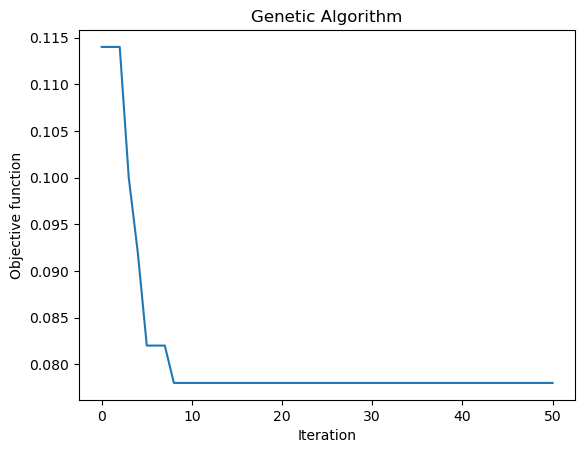

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Experiment logged in MLFlow.
Accuracy: 0.8960, F1 Score: 0.8961
🏃 View run GA_Feature_Selection_Stacking at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/15/runs/ae185f554fb145f5977b54da5e23842b
🧪 View experiment at: https://dagshub.com/sreenathreddy6633/price-detection.mlflow/#/experiments/15


In [53]:
!pip install geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import mlflow
from dagshub import dagshub_logger



# Feature selection using Genetic Algorithm
def fitness_function(features):
    """Fitness function to evaluate model performance for a given feature subset."""
    selected_features = np.where(features == 1)[0]  # Indices of selected features
    if len(selected_features) == 0:  # Avoid models with no features
        return 1  # High fitness value means bad performance
    
    # Train-test split on selected features
    X_train_subset = X_train.iloc[:, selected_features]
    X_test_subset = X_test.iloc[:, selected_features]

    # Train a simple model (e.g., Random Forest)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)

    # Use 1 - accuracy as the fitness value (lower is better)
    accuracy = accuracy_score(y_test, y_pred)
    return 1 - accuracy

# Define Genetic Algorithm parameters
num_features = X.shape[1]
algorithm = ga(
    function=fitness_function,
    dimension=num_features,
    variable_type="bool",  # Binary selection (0 = exclude, 1 = include)
    algorithm_parameters={
        "max_num_iteration": 50,
        "population_size": 20,
        "mutation_probability": 0.1,
        "elit_ratio": 0.01,
        "crossover_probability": 0.5,
        "parents_portion": 0.3,
        "crossover_type": "uniform",
        "max_iteration_without_improv": None
    }
)

# Run Genetic Algorithm for feature selection
algorithm.run()
selected_features = np.where(algorithm.output_dict["variable"] == 1)[0]

# Use selected features for stacking model
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]


# Define Stacking Classifier
base_models = [
    ("lr", LogisticRegression(max_iter=1000, random_state=42)),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
]
meta_model = XGBClassifier(random_state=42, n_jobs=-1)
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method="predict_proba",
    n_jobs=-1
)

# Train Stacking Classifier on selected features
stacking_model.fit(X_train_selected, y_train)
y_pred = stacking_model.predict(X_test_selected)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

# Log results in MLFlow
mlflow.set_tracking_uri("https://dagshub.com/sreenathreddy6633/price-detection.mlflow")  # Replace with your DagsHub repo
mlflow.set_experiment("Experiment_7")

with dagshub_logger() as logger:
    with mlflow.start_run(run_name="GA_Feature_Selection_Stacking"):
        # Log selected features
        mlflow.log_param("selected_features", X.columns[selected_features].tolist())

        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)

        logger.log_metrics({"accuracy": accuracy, "f1_score": f1})
        print("Experiment logged in MLFlow.")
        print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Meaningful F1-score plots 

                              run_id  F1-Score                       Run Name  \
9   67a1696f21d247328066e8a3d1caa54f  0.971902             LogisticRegression   
17  1c1a6555bb824489aa480056c3bf977f  0.961923             LogisticRegression   
5   c04e0a6e94134c52996fdf1b8f074247  0.959901             LogisticRegression   
13  c77bd0fc4b8149d3923d021a438a2bd7  0.949940             LogisticRegression   
2   1735032967ce4977b2ccda8829fd8e20  0.928329                  XGBClassifier   
3   2ae2fc313aa442df81e4f9fe99ea7586  0.924218         RandomForestClassifier   
14  4fd96a95a37543779bcdd1bbe88f42b4  0.900045                  XGBClassifier   
7   bc544089e6184f9797860bf1238e3138  0.899912         RandomForestClassifier   
10  9b6c65a3542d49d89e54e31699460865  0.898309                  XGBClassifier   
0   ae185f554fb145f5977b54da5e23842b  0.896059  GA_Feature_Selection_Stacking   
6   2080c72cfbc347a5a1486ca64a60d909  0.895842                  XGBClassifier   
11  9173dc4a702d47128573f40c

/var/folders/ky/31mx8kz15pl2l2g5yc3h61280000gn/T/ipykernel_51363/3202119120.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


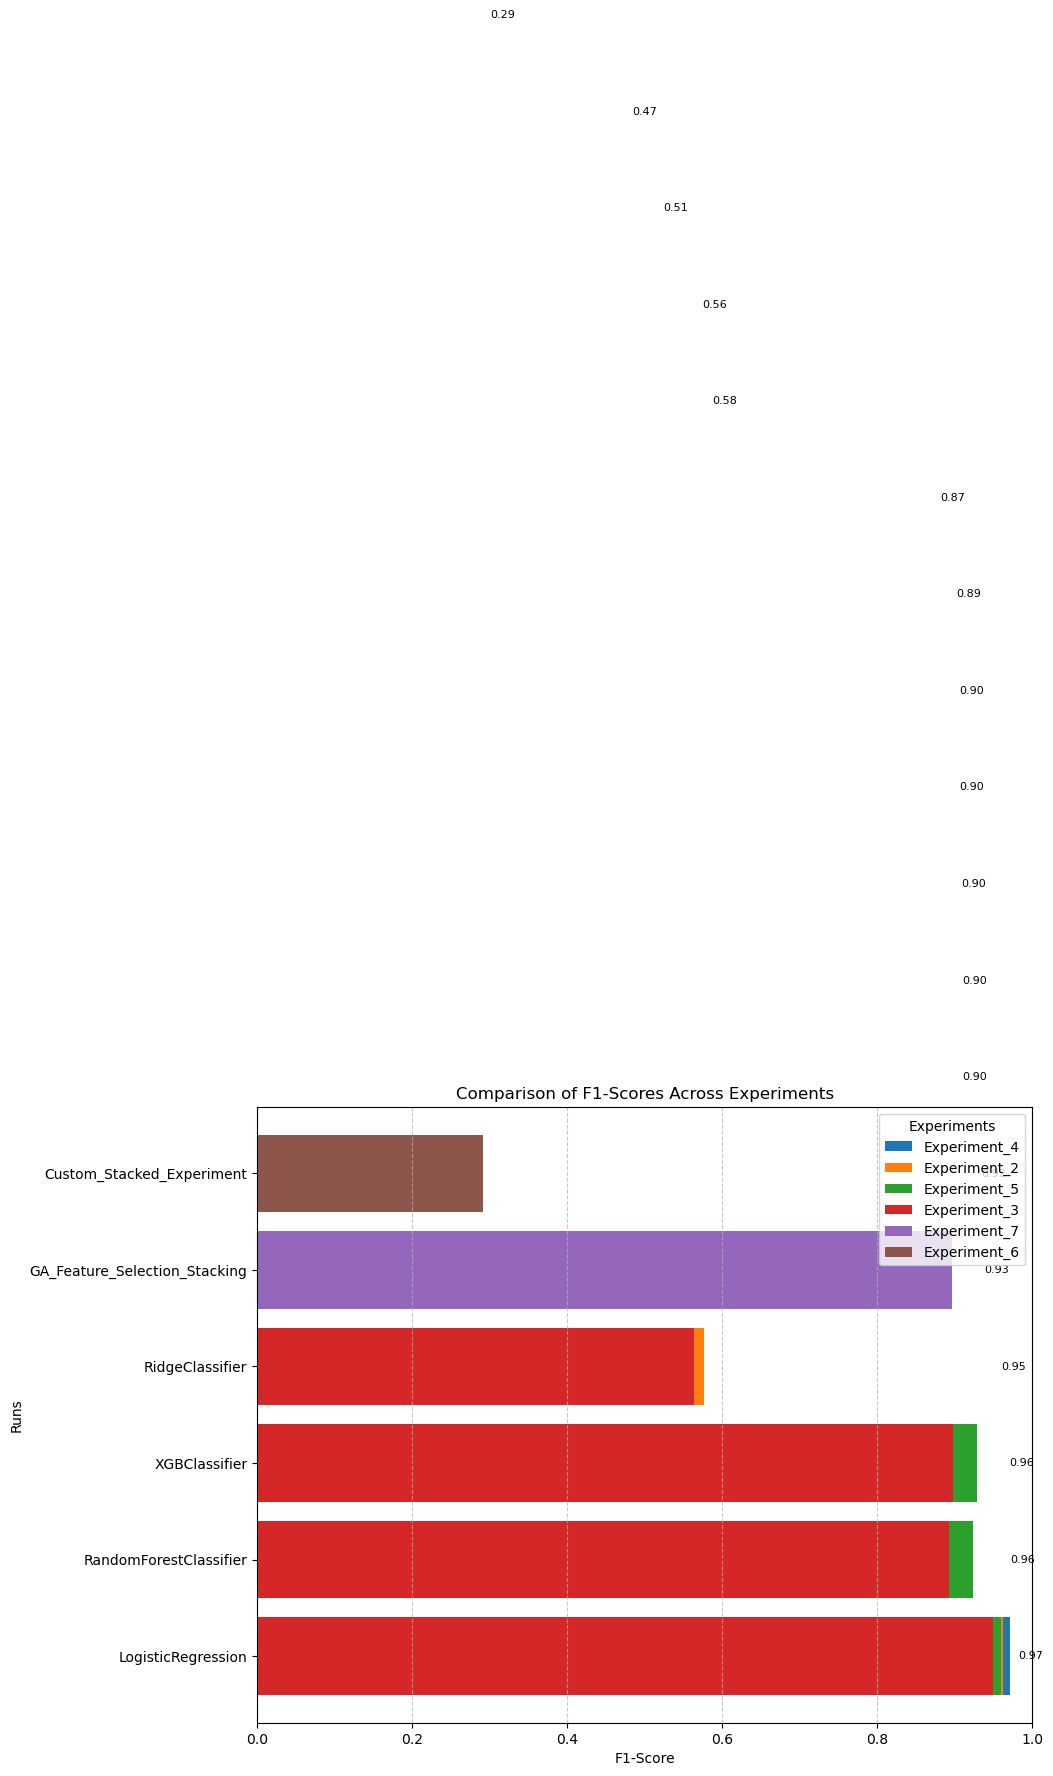

In [63]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

# Set the tracking URI for MLFlow (update with your MLFlow server URI if needed)
mlflow.set_tracking_uri("https://dagshub.com/sreenathreddy6633/price-detection.mlflow")  # Replace with your MLFlow tracking server

# Fetch all experiments
experiments = mlflow.search_experiments()
all_f1_scores = []

# Loop through each experiment
for experiment in experiments:
    experiment_id = experiment.experiment_id
    experiment_name = experiment.name

    # Get all runs for the experiment
    runs = mlflow.search_runs(experiment_ids=[experiment_id])

    # Extract F1-scores and corresponding run names
    if "metrics.f1_score" in runs.columns:
        f1_scores = runs[["run_id", "metrics.f1_score", "tags.mlflow.runName"]].dropna()
        f1_scores = f1_scores.rename(
            columns={
                "metrics.f1_score": "F1-Score",
                "tags.mlflow.runName": "Run Name"
            }
        )
        f1_scores["Experiment"] = experiment_name
        all_f1_scores.append(f1_scores)

# Combine F1-scores from all experiments
if all_f1_scores:
    combined_f1_scores = pd.concat(all_f1_scores, ignore_index=True)
else:
    raise ValueError("No F1-scores found in any experiments.")

# Sort by F1-Score for better visualization
combined_f1_scores = combined_f1_scores.sort_values(by="F1-Score", ascending=False)

# Display the F1-scores
print(combined_f1_scores)

# Plot the F1-scores
plt.figure(figsize=(10, 8))
for experiment_name in combined_f1_scores["Experiment"].unique():
    exp_data = combined_f1_scores[combined_f1_scores["Experiment"] == experiment_name]
    plt.barh(exp_data["Run Name"], exp_data["F1-Score"], label=experiment_name)

plt.xlabel("F1-Score")
plt.ylabel("Runs")
plt.title("Comparison of F1-Scores Across Experiments")
plt.legend(title="Experiments")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.xlim(0, 1)  # F1-scores are between 0 and 1

# Annotate bars with F1-scores
for i, score in enumerate(combined_f1_scores["F1-Score"]):
    plt.text(score + 0.01, i, f"{score:.2f}", va="center", fontsize=8)

plt.tight_layout()
plt.show()

<li> After final Analysis it is found from above graph that logistic regression was superior in terms of f1 score than any other model used in all instances. </li>
<li> Logistic Regression model from Experiment 4 gave best results</li>

In [ ]:
import joblib

In [99]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X_train_selected, y_train)

# Save the entire pipeline
joblib.dump(pipeline, "logistic_model.pkl")

['logistic_model.pkl']

In [103]:
y_pred = pipeline.predict(X_test_selected)
print(f1_score(y_pred, y_test, average='weighted'))

0.9720025639730556


In [107]:
X_test_selected.head()

,battery_power,mobile_wt,ram,dual_sim,touch_screen,pc,sc_h,px_height,px_width
1860,1646,200,686,0,1,5,8,211,1608
353,1182,138,2563,0,0,16,19,275,986
1333,1972,196,1316,0,1,18,8,293,952
905,989,166,3892,0,1,19,18,256,1394
1289,615,130,1906,1,0,8,14,1021,1958
